In [1]:
import pandas as pd
from pulp import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%%html
<style>
.dataframe td {
    white-space: nowrap;
}
</style>

In [3]:
SMALL_SIZE = 8
MEDIUM_SIZE = 12
BIGGER_SIZE = 13

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Parameters
#### Project List

In [4]:
# Projects List
df_p = pd.read_excel('warehouses.xlsx', sheet_name='projects')

for COL in ['TURNOVER', 'YEAR 1', 'YEAR 2', 'YEAR 3', 'ROI']:
    df_p[COL] =  df_p[COL].fillna(0).astype(int)
    
# Create project description linked to the customer
df_p['PROJECT DESCRIPTION'] = df_p['PROJECT DESCRIPTION'].astype(str) + '-' + df_p['CUSTOMER']
    
print("{:,} projects in your list".format(len(df_p)))
df_p.head()

58 projects in your list


,PROJECT NUMBER,PROJECT DESCRIPTION,CUSTOMER,VERTICAL,WH,SQM,COUNTRY,TURNOVER,YEAR 1,YEAR 2,YEAR 3,TOTAL,ROI,OPERATIONS,SUSTAINABILITY,BUSINESS DEV,HSE,DIGITAL TRANSFORMATION,CSR,OPERATIONAL EXCELLENCE
0,1,5S VISUAL MANAGEMENT-LUXURY 3,LUXURY 3,LUXURY,WH01,4000,CHINA,5000000,11500,3500,2450,17450,-750,WAREHOUSING,False,False,True,False,False,True
1,2,ADDITIONAL SPACE WITH RACKING-LUXURY 4,LUXURY 4,LUXURY,WH06,1200,CHINA,1200000,200000,250000,300000,750000,180000,WAREHOUSING,False,True,False,False,False,False
2,3,ADDITIONAL SPACE WITH RACKING-AUTOMOTIVE 1,AUTOMOTIVE 1,AUTOMOTIVE,WH02,4500,SINGAPORE,4500000,220000,320000,350000,890000,213600,WAREHOUSING,False,True,False,False,False,False
3,4,ADDITIONAL SPACE WITH RACKING-FASHION 1,FASHION 1,FASHION,WH01,2000,CHINA,1000000,75000,100000,110000,285000,49875,WAREHOUSING,False,True,False,False,False,False
4,5,ADDITIONAL SPACE WITH RACKING-FASHION 2,FASHION 2,FASHION,WH01,500,CHINA,850000,90000,110000,130000,330000,70620,WAREHOUSING,False,True,False,False,False,False


### Exploratory Data Analysis
#### Number of Projects per Vertical

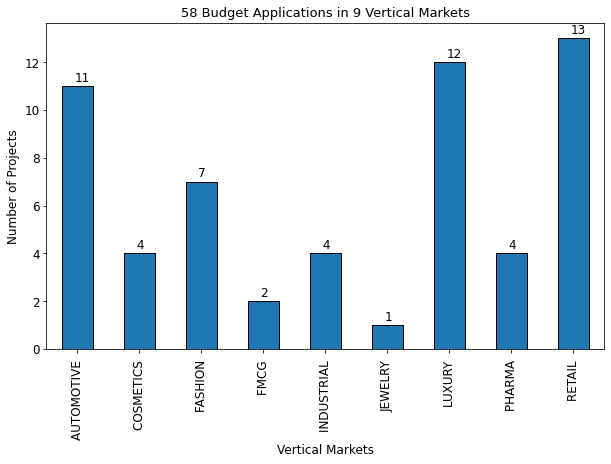

In [5]:
# Bar Chart
df_bar = pd.DataFrame(df_p.groupby(['VERTICAL'])['PROJECT NUMBER'].count())
ax = df_bar.plot.bar(figsize=(10, 6), edgecolor='black', y='PROJECT NUMBER', legend= False)
plt.xlabel('Vertical Markets')
plt.ylabel('Number of Projects')
plt.title('{} Budget Applications in 9 Vertical Markets'.format(len(df_p)))

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1 +0.2, p.get_height() * 1 + 0.2))

plt.show()

#### Budget Applications Amounts per Vertical

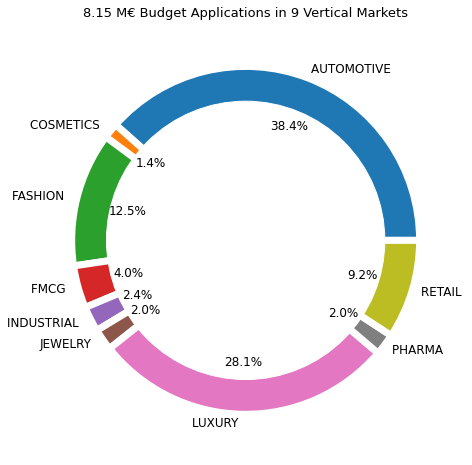

In [6]:
my_circle = plt.Circle( (0,0), 0.8, color='white')
df_p.groupby(['VERTICAL']).sum().plot.pie(figsize=(8, 8), y='TOTAL', legend= False, pctdistance=0.7,
                                          autopct='%1.1f%%', labeldistance=1.05, 
                                          wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })
plt.xlabel('Business Vertical')
plt.title('{:.2f} M€ Budget Applications in 9 Vertical Markets'.format(df_p['TOTAL'].sum()/1e6))
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.axis('off')
plt.show()

#### Budget Applications Amounts per Country

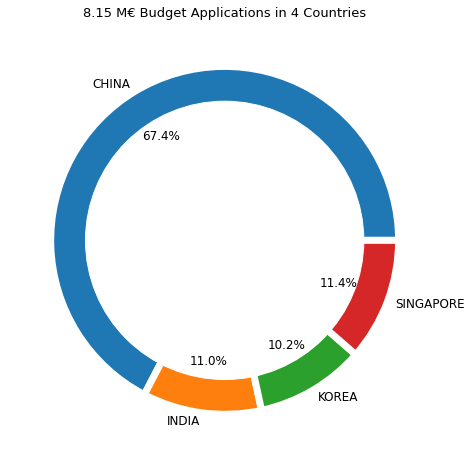

In [7]:
# Chart
df_budg = pd.DataFrame((df_p.groupby(['COUNTRY'])['TOTAL'].sum()/1e6).round(2))
my_circle = plt.Circle( (0,0), 0.8, color='white')
df_budg.plot.pie(figsize=(8, 8), y='TOTAL', legend= False, pctdistance=0.7,
                                          autopct='%1.1f%%', labeldistance=1.05, 
                                          wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })
plt.xlabel('Business Vertical')
plt.ylabel('(M€)')
plt.title('{:.2f} M€ Budget Applications in 4 Countries'.format(df_p['TOTAL'].sum()/1e6))
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.axis('off')
plt.show()

#### Budget Allocation for each Management Objective

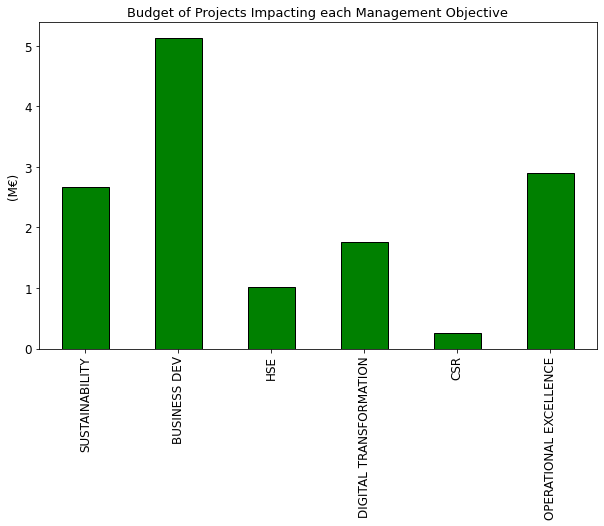

In [8]:
# Bar Chart
OBJ = ['SUSTAINABILITY', 'BUSINESS DEV', 'HSE', 'DIGITAL TRANSFORMATION',
       'CSR', 'OPERATIONAL EXCELLENCE']
df_obj = df_p.copy()
for COL in OBJ:
    df_obj[COL] = df_obj[COL] * df_obj['TOTAL']
df_obj = pd.DataFrame(df_obj[OBJ].sum(axis = 0)/1E6)
df_obj.columns = ['BUDGET']


ax = df_obj.plot.bar(figsize=(10, 6), edgecolor='black', y='BUDGET', color = 'green', legend= False)
# plt.xlabel('Business Vertical')
plt.ylabel('(M€)')
plt.title('Budget of Projects Impacting each Management Objective'.format(len(df_p)))
plt.show()

### Model 1: Maximize ROI

In [9]:
# 1. Initiliaze Class
model = LpProblem("Budget_Planning_MaxROI", LpMaximize)

# 2. Define Decision Variables
# Project Name
projects = list(df_p['PROJECT DESCRIPTION'].values)
# Project ROI
roi = list(df_p['ROI'].values)
# Distionnary
P =  LpVariable.dicts("P", [j for j in range(len(projects))],
                     lowBound=0, cat='Binary')

# 3. Define Objective Function
# Total Return of Investment
model += lpSum([roi[i] * P[i] for i in range(len(projects))]) 


# 4. Define Constraints
# Maximum budget for Year 1, Year 2 and Year 3
BUGDET_LIMIT = [1250000, 1500000, 1750000]
for j in range(3):
    model += lpSum([P[i] * df_p.loc[i, 'YEAR {}'.format(j+1)] for i in range(len(projects))]) <= BUGDET_LIMIT[j]

# Solve Model
status = model.solve()
print(LpStatus[status])
print("Return of Investment = {:,} Euros".format(
    round(value(model.objective), 2)))

# Results
MAX_BUDGET = sum(BUGDET_LIMIT)/1e6
ACTUAL_BUDGET = round(sum([P[i].varValue * df_p.loc[i, 'TOTAL'] for i in range(len(projects))])/1e6,2)
project_allocation = int(sum([P[i].varValue for i in range(len(projects))]))
LIST_PROJECTS = []
for j in range(len(projects)):
    LIST_PROJECTS.append(P[j].varValue)
    
print('{}/{} Projects Accepted with a Budget Allocation of {:,}/{:,} M€'.format(project_allocation, 
                                                                                len(df_p), ACTUAL_BUDGET, MAX_BUDGET))

Optimal
Return of Investment = 1,050,976.0 Euros
36/58 Projects Accepted with a Budget Allocation of 4.07/4.5 M€


#### Add the Results

In [10]:
# Results
df_result = df_p.copy()
df_result['ALLOCATION'] = LIST_PROJECTS
df_result['TOTAL'] = df_result['ALLOCATION'] * df_result['TOTAL']
df_result['ROI'] = df_result['ALLOCATION'] * df_result['ROI']

#### Number of Projects per Vertical

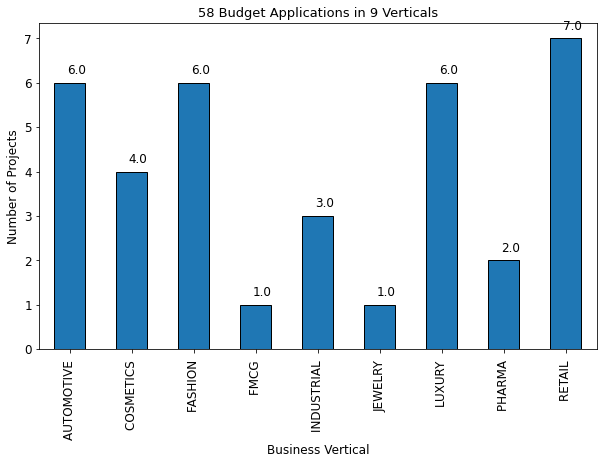

In [11]:
# Bar Chart
df_bar = pd.DataFrame(df_result.groupby(['VERTICAL'])['ALLOCATION'].sum())
ax = df_bar.plot.bar(figsize=(10, 6), edgecolor='black', y='ALLOCATION', legend= False)
plt.xlabel('Business Vertical')
plt.ylabel('Number of Projects')
plt.title('{} Budget Applications in 9 Verticals'.format(len(df_p)))

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1 +0.2, p.get_height() * 1 + 0.2))

plt.show()

-- COMPARE THE TWO GRAPHS

#### Budget Allocations Amounts per Country

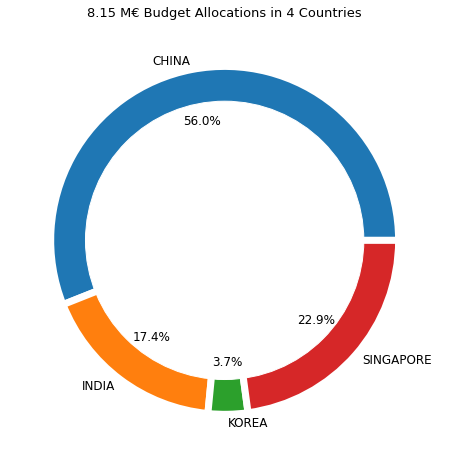

In [12]:
# Chart
df_budg = pd.DataFrame((df_result.groupby(['COUNTRY'])['TOTAL'].sum()/1e6).round(2))
my_circle = plt.Circle( (0,0), 0.8, color='white')
df_budg.plot.pie(figsize=(8, 8), y='TOTAL', legend= False, pctdistance=0.7,
                                          autopct='%1.1f%%', labeldistance=1.05, 
                                          wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })
plt.xlabel('Business Vertical')
plt.ylabel('(M€)')
plt.title('{:.2f} M€ Budget Allocations in 4 Countries'.format(df_p['TOTAL'].sum()/1e6))
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.axis('off')
plt.show()

#### Budget Allocation for each Management Objective

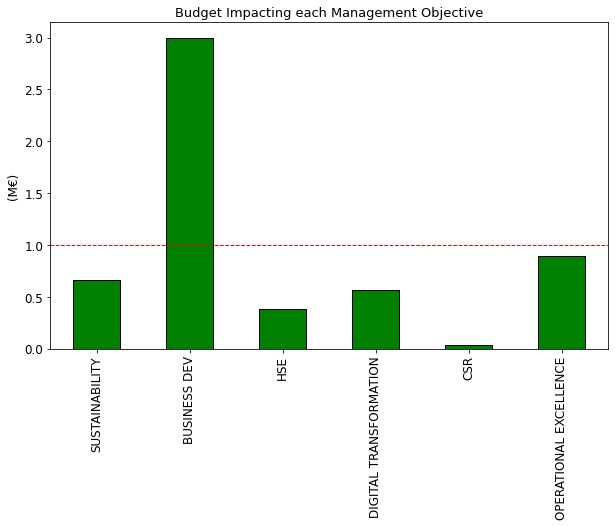

In [13]:
# Bar Chart
OBJ = ['SUSTAINABILITY', 'BUSINESS DEV', 'HSE', 'DIGITAL TRANSFORMATION',
       'CSR', 'OPERATIONAL EXCELLENCE']
df_obj = df_result.copy()
for COL in OBJ:
    df_obj[COL] = df_obj[COL] * df_obj['TOTAL']
df_obj = pd.DataFrame(df_obj[OBJ].sum(axis = 0)/1E6)
df_obj.columns = ['BUDGET']


ax = df_obj.plot.bar(figsize=(10, 6), edgecolor='black', y='BUDGET', color = 'green', legend= False)
# plt.xlabel('Business Vertical')
plt.ylabel('(M€)')
plt.title('Budget Impacting each Management Objective'.format(len(df_p)))
ax.axhline(1 , color="red", linestyle="--", linewidth = 1.0)
plt.show()

### Model 2: Management Guidelines

In [14]:
# 1. Initiliaze Class
model = LpProblem("Budget_Planning_MaxROI", LpMaximize)

# 2. Define Decision Variables
# Project Name
projects = list(df_p['PROJECT DESCRIPTION'].values)
# Project ROI
roi = list(df_p['ROI'].values)
# Dictionnary
P =  LpVariable.dicts("P", [j for j in range(len(projects))],
                     lowBound=0, upBound=None, cat='Binary')

# 3. Define Objective Function
# Total Return of Investment
model += lpSum([roi[i] * P[i] for i in range(len(projects))]) 


# 4. Define Constraints
# Maximum budget for Year 1, Year 2 and Year 3
BUGDET_LIMIT = [1250000, 1500000, 1750000]
for j in range(3):
    model += lpSum([P[i] * df_p.loc[i, 'YEAR {}'.format(j+1)] for i in range(len(projects))]) <= BUGDET_LIMIT[j]
# List of Boolean for Operational Excellence, Sustainability and Digital Transformation
O = df_p['OPERATIONAL EXCELLENCE'].values * 1 
S = df_p['SUSTAINABILITY'].values * 1 
D = df_p['DIGITAL TRANSFORMATION'].values * 1 
# Management Objectives
BUDGET_MIN = [1000000, 1000000, 1000000]
model += lpSum([P[i] * O[i] * df_p.loc[i, 'TOTAL'] for i in range(len(projects))]) >= BUDGET_MIN[0]
model += lpSum([P[i] * S[i] * df_p.loc[i, 'TOTAL'] for i in range(len(projects))]) >= BUDGET_MIN[1]
model += lpSum([P[i] * D[i] * df_p.loc[i, 'TOTAL'] for i in range(len(projects))]) >= BUDGET_MIN[2]


# Solve Model
status = model.solve()
print(LpStatus[status])
print("Return of Investment = {:,} Euros".format(
    round(value(model.objective), 2)))

# Results
MAX_BUDGET = sum(BUGDET_LIMIT)/1e6
ACTUAL_BUDGET = round(sum([P[i].varValue * df_p.loc[i, 'TOTAL'] for i in range(len(projects))])/1e6,2)
project_allocation = int(sum([P[i].varValue for i in range(len(projects))]))
LIST_PROJECTS = []
for j in range(len(projects)):
    LIST_PROJECTS.append(P[j].varValue)
    
print('{}/{} Projects Accepted with a Budget Allocation of {:,}/{:,} M€'.format(project_allocation, 
                                                                                len(df_p), ACTUAL_BUDGET, MAX_BUDGET))

Optimal
Return of Investment = 909,989.0 Euros
34/58 Projects Accepted with a Budget Allocation of 4.15/4.5 M€


#### Add the Results

In [15]:
# Results
df_result = df_p.copy()
df_result['ALLOCATION'] = LIST_PROJECTS
df_result['TOTAL'] = df_result['ALLOCATION'] * df_result['TOTAL']
df_result['ROI'] = df_result['ALLOCATION'] * df_result['ROI']

#### Number of Projects per Vertical

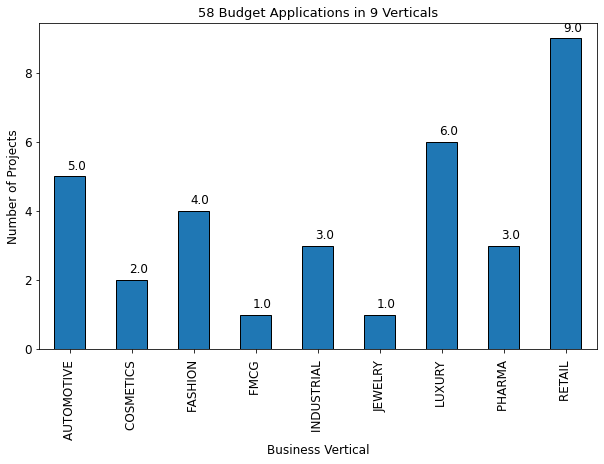

In [16]:
# Bar Chart
df_bar = pd.DataFrame(df_result.groupby(['VERTICAL'])['ALLOCATION'].sum())
ax = df_bar.plot.bar(figsize=(10, 6), edgecolor='black', y='ALLOCATION', legend= False)
plt.xlabel('Business Vertical')
plt.ylabel('Number of Projects')
plt.title('{} Budget Applications in 9 Verticals'.format(len(df_p)))

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1 +0.2, p.get_height() * 1 + 0.2))

plt.show()

#### Budget Allocations Amounts per Country

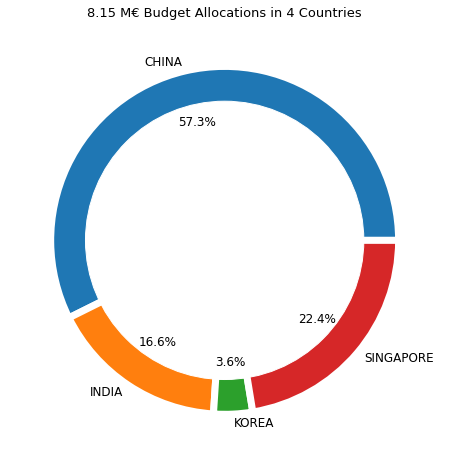

In [17]:
# Chart
df_budg = pd.DataFrame((df_result.groupby(['COUNTRY'])['TOTAL'].sum()/1e6).round(2))
my_circle = plt.Circle( (0,0), 0.8, color='white')
df_budg.plot.pie(figsize=(8, 8), y='TOTAL', legend= False, pctdistance=0.7,
                                          autopct='%1.1f%%', labeldistance=1.05, 
                                          wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })
plt.xlabel('Business Vertical')
plt.ylabel('(M€)')
plt.title('{:.2f} M€ Budget Allocations in 4 Countries'.format(df_p['TOTAL'].sum()/1e6))
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.axis('off')
plt.show()

#### Budget Allocation for each Management Objective

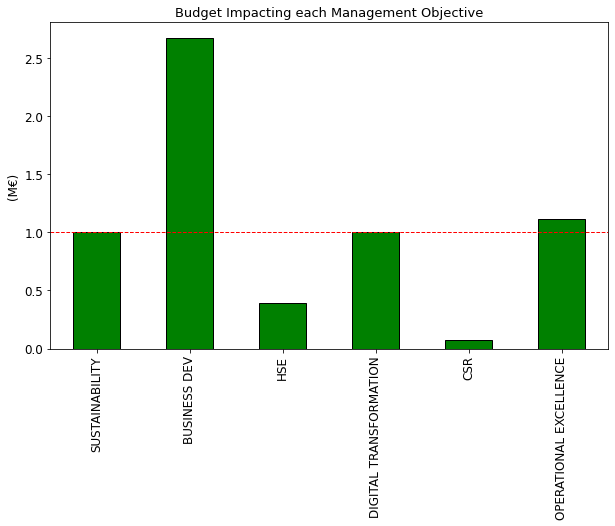

In [18]:
# Bar Chart
OBJ = ['SUSTAINABILITY', 'BUSINESS DEV', 'HSE', 'DIGITAL TRANSFORMATION',
       'CSR', 'OPERATIONAL EXCELLENCE']
df_obj = df_result.copy()
for COL in OBJ:
    df_obj[COL] = df_obj[COL] * df_obj['TOTAL']
df_obj = pd.DataFrame(df_obj[OBJ].sum(axis = 0)/1E6)
df_obj.columns = ['BUDGET']


ax = df_obj.plot.bar(figsize=(10, 6), edgecolor='black', y='BUDGET', color = 'green', legend= False)
# plt.xlabel('Business Vertical')
plt.ylabel('(M€)')
plt.title('Budget Impacting each Management Objective'.format(len(df_p)))
ax.axhline(1 , color="red", linestyle="--", linewidth = 1.0)
plt.show()

### Selected Projects

In [19]:
df_result[df_result['ALLOCATION']==1][df_result.columns[0:7]]

,PROJECT NUMBER,PROJECT DESCRIPTION,CUSTOMER,VERTICAL,WH,SQM,COUNTRY
1,2,ADDITIONAL SPACE WITH RACKING-LUXURY 4,LUXURY 4,LUXURY,WH06,1200,CHINA
2,3,ADDITIONAL SPACE WITH RACKING-AUTOMOTIVE 1,AUTOMOTIVE 1,AUTOMOTIVE,WH02,4500,SINGAPORE
4,5,ADDITIONAL SPACE WITH RACKING-FASHION 2,FASHION 2,FASHION,WH01,500,CHINA
9,10,AUTOMATED ORDER PICKER (PRODUCTIVITY)-JEWELRY 1,JEWELRY 1,JEWELRY,WH01,2000,CHINA
10,11,"AUTOMATED WRAPPING MACHINE (SUSTAINABILITY, PR...",LUXURY 1,LUXURY,WH01,10000,CHINA
11,12,"AUTOMATED WRAPPING MACHINE (SUSTAINABILITY, PR...",RETAIL 4,RETAIL,WH05,1000,CHINA
12,13,AUTOMATIC DIMENSIONING SYSTEM TO MEASURE INBO...,PHARMA 2,PHARMA,WH17,10000,INDIA
13,14,AUTONOMOUS ROBOT FOR INVENTORY STOCK COUNT (PR...,PHARMA 2,PHARMA,WH17,10000,INDIA
14,15,AUTONOMOUS SCALE FOR PARCEL DOUBLE CHECK BEFOR...,AUTOMOTIVE 1,AUTOMOTIVE,WH02,4500,SINGAPORE
16,17,"COLD ROOM RENOVATION (CSR, BUSINESS OPPORTUNIT...",RETAIL 3,RETAIL,WH04,2500,CHINA
